In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib
from matplotlib        import pyplot as plt
from matplotlib        import cm
from matplotlib.ticker import LinearLocator

WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import cantera         as ct

from scipy.integrate   import solve_ivp, ode

In [2]:
OutDir   = WORKSPACE_PATH + '/ROMNet/Data/ReacEq/'
FigDir   = OutDir + '/Figs/'

T0       = 300.
P0       = 10. * ct.one_atm
TTran    = 1000.

nx       = 2     # number of collocation points
Lx       = 1.0   # domain size 

IntegFlg = True
tMin     = 1.e-4
tMax     = 5.e-1
dt0      = 1.e-6
tStratch = 1.1

In [3]:
try:
    os.makedirs(OutDir)
except OSError as e:
    pass
try:
    os.makedirs(FigDir)
except OSError as e:
    pass

In [4]:
### Create Mixture

gas        = ct.Solution('gri30.yaml', energy_enabled=False)
gas.TPX    = T0, P0, 'CH4:0.5, O2:1, N2:3.76'
rho0       = gas.density
ns         = gas.n_species

yOrigNames = gas.species_names

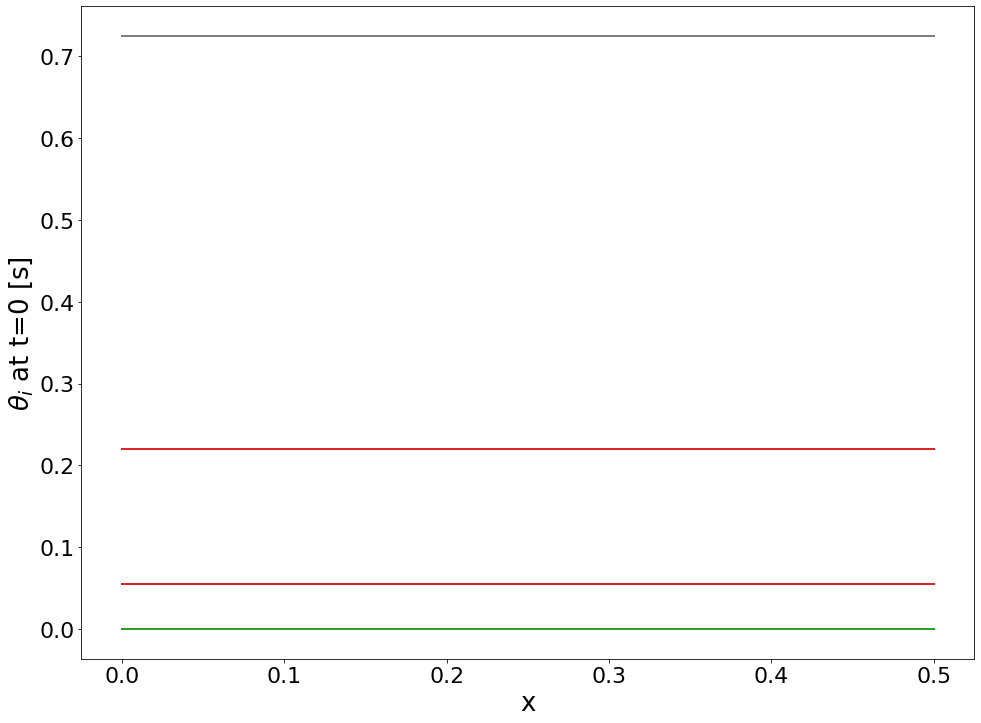

In [5]:
#DIFFUSION-REACTION OF MULTIPLE SCALARS

dx = Lx/nx           # grid spacing
X  = np.zeros((ns,nx))
x  = np.zeros(nx*ns) 
for iS in range(0,ns):
    x[0+iS*nx:nx+iS*nx] = np.linspace(0., Lx-dx, nx)
    X[iS,:]             = np.linspace(0., Lx-dx, nx)
xx = x[0:nx]


#initial profile
#sig = 0.05       
#y0  = 1.0/(sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (x-Lx/2)/sig )**2.  ) * np.repeat([gas.Y], nx)
#y0  = np.repeat([gas.Y[0:-1]], nx)
y0    = np.tile(gas.Y[0:-1], nx)
y0All = np.tile(gas.Y, nx)


Y0 = np.zeros((ns,nx))
for iS in range(ns):
    #Y0[iS,:] = 1.0 / ( sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (X[iS,:]-Lx/2)/sig )**2. ) * gas.Y[iS]    
    Y0[iS,:] = np.ones(nx) * gas.Y[iS]    

fig = plt.figure(figsize=(16, 12))
plt.plot(X.T, Y0.T)
plt.xlabel('x')
plt.ylabel(r'$\theta_i$ at t=0 [s]')

plt.savefig(FigDir+'/y0.png', dpi=900)

In [6]:
# #####################################################################################################
# ### RHS Function
# #def ReacDiffAdvRHS_x(x, y, dx, xx, ns, DiffFun, AdvecFun, ReacFun, gas, T, rho0):
# def ReacDiffAdvRHS_x(x, y):
#     print(x)
    
#     y         = np.append(y, [0]*nx, axis=0)
#     Y         = y.reshape(ns,nx)

#     dYdt_Diff = np.zeros((ns,nx))
#     Y_Adv     = np.zeros((ns,nx))
#     for iX in range(-1,nx-1):
#         DiffM           = DiffFun(xx[iX],  DiffC1, DiffC2)
#         dYdt_Diff[:,iX] = np.matmul(DiffM, (Y[:,iX+1] - Y[:,iX-1]) / (2.*dx) )
#         AdvecM          = AdvecFun(xx[iX], AdvecC1, AdvecC2)
#         Y_Adv[:,iX]     = np.matmul(AdvecM, Y[:,iX])
        
#     dYdt      = np.zeros((ns-1,nx))    
#     for iX in range(-1,nx-1):
#         Diff       = (dYdt_Diff[:,iX+1] - dYdt_Diff[:,iX-1]) / (2.*dx)
#         Advec      = (    Y_Adv[:,iX+1] -     Y_Adv[:,iX-1]) / (2.*dx)
       
#         gas.TDY    = T, rho0, Y[:,iX]
#         wdot       = gas.net_production_rates
#         Reac       = wdot * gas.molecular_weights / rho0   
        
#         dYdt[:,iX] = Diff[0:-1] + Advec[0:-1] + Reac[0:-1]
    
#     dydt = dYdt.flatten()
        
#     return dydt
# #####################################################################################################



#####################################################################################################
### RHS Function
#def ReacDiffAdvRHS_x(x, y, dx, xx, ns, DiffFun, AdvecFun, ReacFun, gas, T, rho0):
def ReacDiffAdvRHS_x(x, y):
    print(x)
    
    Y         = y.reshape(nx,ns-1)
    Y         = np.append(Y, np.zeros((nx,1)), axis=1)
    Y[:,-1]   = 1. - np.sum(Y, axis=1)

    dYdt_Diff = np.zeros((nx,ns))
    Y_Adv     = np.zeros((nx,ns))
    for iX in range(-1,nx-1):
        DiffM           = DiffFun(xx[iX],  DiffC1, DiffC2)
        dYdt_Diff[iX,:] = np.matmul(DiffM, (Y[iX+1,:] - Y[iX-1,:]) / (2.*dx) )
        AdvecM          = AdvecFun(xx[iX], AdvecC1, AdvecC2)
        Y_Adv[iX,:]     = np.matmul(AdvecM, Y[iX,:])
        
    dYdt      = np.zeros((nx,ns-1))    
    for iX in range(-1,nx-1):
        Diff       = (dYdt_Diff[iX+1,:] - dYdt_Diff[iX-1,:]) / (2.*dx)
        Advec      = (    Y_Adv[iX+1,:] -     Y_Adv[iX-1,:]) / (2.*dx)
       	
        gas.TDY    = TTran, rho0, Y[iX,:]
        wdot       = gas.net_production_rates
        Reac       = wdot * gas.molecular_weights / rho0   
        
        dYdt[iX,:] = Reac[0:-1]# + Diff[0:-1] + Advec[0:-1]# + 

    dydt = dYdt.flatten() 

    #sys.exit('Enough')
    return dydt
#####################################################################################################

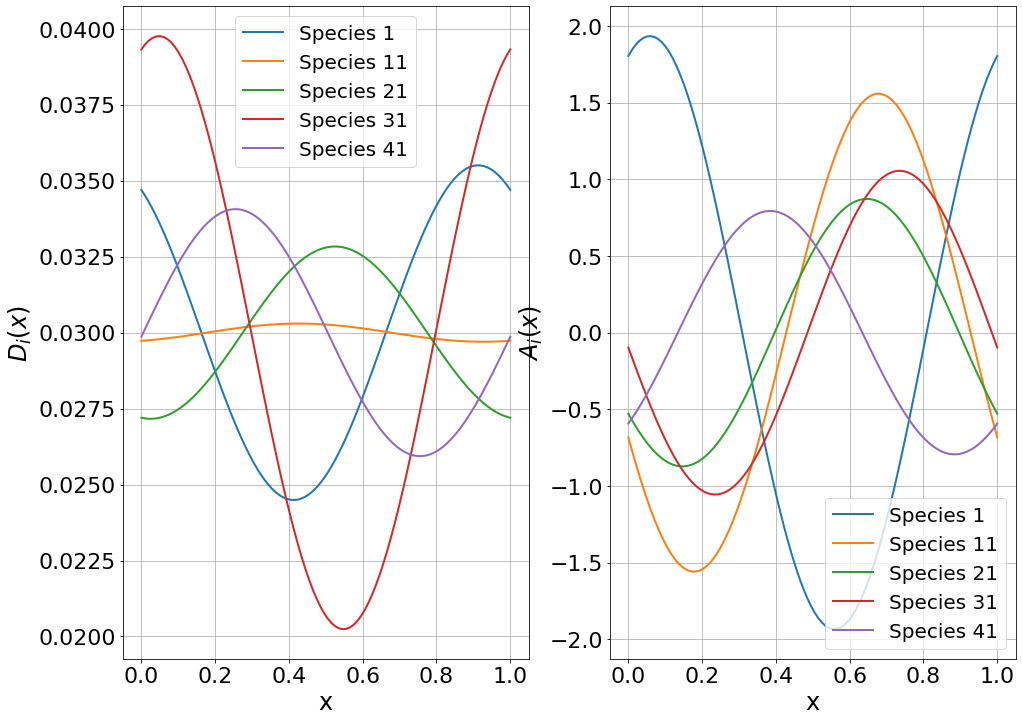

In [7]:
#D     = 0.03*np.ones((ns,1)) 
#Ad    = 1.0*np.ones((ns,1))
#alpha = 3.00*np.ones((ns,1))

# D     = 0.03 + 0.01*np.random.rand(ns)
# Ad    = 1.0*np.random.rand(ns) - 0.5
# alpha = 2.0*np.random.rand(ns) - 1.0

# D     = np.diag(D)
# Ad    = np.diag(Ad)
# alpha = np.diag(alpha)

np.random.seed(3)
DiffC1 = 0.01*np.random.rand(ns) 
DiffC2 = 2.*np.pi*np.random.rand(ns)
def DiffFun(x, DiffC1, DiffC2):
    DiffV  = DiffC1 * np.cos(x*(2.*np.pi)+DiffC2) + 0.03
    DiffM  = np.diag(DiffV)
    return DiffM


np.random.seed(4)
AdvecC1 = 2.*np.random.rand(ns)
AdvecC2 = 2.*np.pi*np.random.rand(ns)
def AdvecFun(x, AdvecC1, AdvecC2):
    AdvecV  = AdvecC1 * np.sin(x*(2.*np.pi) + AdvecC2)
    AdvecM  = np.diag(AdvecV)
    return AdvecM


NTemp      = 100
DiffMPlot  = np.zeros((ns,NTemp))
AdvecMPlot = np.zeros((ns,NTemp))
ix         = 0
xTemp      = np.linspace(0.,1.,NTemp)
for ix in range(NTemp):
    DiffMPlot[:,ix]  = np.diag(DiffFun(xTemp[ix], DiffC1, DiffC2))
    AdvecMPlot[:,ix] = np.diag(AdvecFun(xTemp[ix], AdvecC1, AdvecC2))
    ix+=1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
Slice = list(range(0,50,10))

ax1.plot(xTemp, DiffMPlot[Slice].T)
ax1.legend(['Species '+str(int(x)+1) for x in Slice], fontsize=20)
ax1.set_xlabel('x', fontsize=24)
ax1.set_ylabel(r'$D_i(x)$', fontsize=24)
#ax1.set_xticks(fontsize=20)
#ax1.set_yticks(fontsize=20)
ax1.grid()

ax2.plot(xTemp, AdvecMPlot[Slice].T)
ax2.legend(['Species '+str(int(x)+1) for x in Slice], fontsize=20)
ax2.set_xlabel('x', fontsize=24)
ax2.set_ylabel(r'$A_i(x)$', fontsize=24)
#ax2.set_xticks(fontsize=20)
#ax2.set_yticks(fontsize=20)
ax2.grid()

#plt.savefig(FigDir+'/Diff_Advec.png', dpi=900)

In [8]:
if (IntegFlg):

    tVec     = [0.0]
    t        = tMin
    dt       = dt0
    while (t <= tMax):
        tVec.append(t)
        t   = t + dt
        dt *= tStratch
    Nt = len(tVec)


    xMat  = np.zeros((ns,nx))
    for i in range(0,ns):
        xMat[i,:] =  x[0+i*nx:nx+i*nx]

    #output  = solve_ivp( ReacDiffAdvRHS_x, (tVec[0],tVec[-1]), y0, method='BDF', t_eval=tVec, rtol=1.e-6 )
    output  = solve_ivp( ReacDiffAdvRHS_x, (tVec[0],tVec[-1]), y0, method='BDF')
    y_next = []
    Nt     = output.y.shape[1]
    for it in range(Nt):
        y_next.append(output.y[:,it])
        
    tVec  = output.t
    
    yTemp = np.zeros((ns,nx))
    for it in range(Nt):
        for ix in range(0,nx):
            yTemp[0:ns-1,ix] = y_next[it][ix*(ns-1):(ix+1)*(ns-1)]
        yTemp[ns-1,:] = 1.0 - np.sum(yTemp, axis=0)
        if (it == 0):
            yMat = yTemp+0
        else:
            yMat = np.concatenate((yMat,yTemp), axis=1)

    DF = pd.DataFrame(np.concatenate((np.repeat(np.array(tVec), nx)[...,np.newaxis], yMat.T), axis=1), columns=['t']+gas.species_names)
    DF.to_csv(OutDir+'/OrigData.csv', index=False)
    
else:
    
    DF   = pd.read_csv(OutDir+'/OrigData.csv')
    tVec = np.unique(DF['t'].to_numpy())
    yMat = DF[gas.species_names].to_numpy().T
    Nt   = int(yMat.shape[1]/nx)

0.0
0.044659571248472266
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.429824563341918e-05
2.429824563341918e-05
4.859649126683836e-05
4.859649126683836e-05
0.00029157894760103016
0.00029157894760103016
0.000534561403935222
0.000534561403935222
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0.002394244312034528
0

0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.010677815836543909
0.01067781583

0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.019635460319019044
0.01882476872770511
0.01882476872770511
0.018419422932048145
0.018419422932048145
0.018419422932048145
0.018824768727705114
0.018824768727705114
0.0192301145233

0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406
0.02320232263615406


0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.02397700514579301
0.023752995669617152
0.023752995669617152
0.023640990931529222
0.023640990931529222
0.02358498856248526
0.02358498856248526
0.02355698737796328
0.02355698737796328
0.02354298678570229
0.02354298678570229
0.023535986489571795
0.023535986489571795
0.023532486341506544
0.023532486341506544
0.02353073626747392
0.02353073626747392
0.02352986123045761
0.02352986123045761
0.023530736267473925
0.023530736267473925
0.02353161130449024
0.02353161130449024
0.023540361674653384
0.023540361674653384
0.023540361674653384
0.023540361674653384
0.023540361674653384
0.023540361674653384
0.023540361674653384
0.0

0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.02547402883333044
0.025850056143683735
0.025850056143683735
0.02622608345403703
0.02622608345403703
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.026965608479582587
0.0269656084795825

0.027706577889943667
0.027706577889943667
0.027706577889943667
0.02770730008235143
0.02770730008235143
0.02770802227475919
0.02770802227475919
0.027715244198836805
0.027715244198836805
0.02772246612291442
0.02772246612291442
0.027729688046992034
0.027729688046992034
0.02780190728776818
0.02780190728776818
0.02787412652854433
0.02787412652854433
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.028246373886756423
0.

0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.030465594877865737
0.029991260659497053
0.029991260659497053
0.029754093550312707
0.029754093550312707
0.029635509995720538
0.029635509995720538
0.029576218218424453
0.029576218218424453
0.029546572329776408
0.029546572329776408
0.029531749385452388
0.02953174938

0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962
0.02992134450503962


0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131
0.03258424634200131


0.03172021702918695
0.03172021702918695
0.031719634328004856
0.031719634328004856
0.0317193429774138
0.0317193429774138
0.03171919730211828
0.03171919730211828
0.03171912446447052
0.03171912446447052
0.03171908804564663
0.03171908804564663
0.031719069836234695
0.031719069836234695
0.03171906073152872
0.03171906073152872
0.03171905617917574
0.03171905617917574
0.03171905390299924
0.03171905390299924
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.03171905617917573
0.0317190561791757

0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081
0.03617137443437081


0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.039673956222366295
0.03967395622

0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.043832696297544466
0.04301264207581937
0.04301264207581937
0.04383269629754447
0.04383269629754447
0.04465275051926958
0.04465275051926958
0.04694245350211457
0.04694245350211457
0.04694245350211457
0.04694245350211457
0.04694245350211457
0.04694245350211457
0.04

0.049915464055278115
0.049915464055278115
0.04994118791879672
0.04994118791879672
0.04996691178231532
0.04996691178231532
0.04999263564583392
0.04999263564583392
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.05024987428101994
0.0502498742810199

0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316
0.05066873591408316


0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492
0.05627278861028492


0.13035743221583754
0.13035743221583754
0.15340588777461206
0.15340588777461206
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658
0.17645434333338658


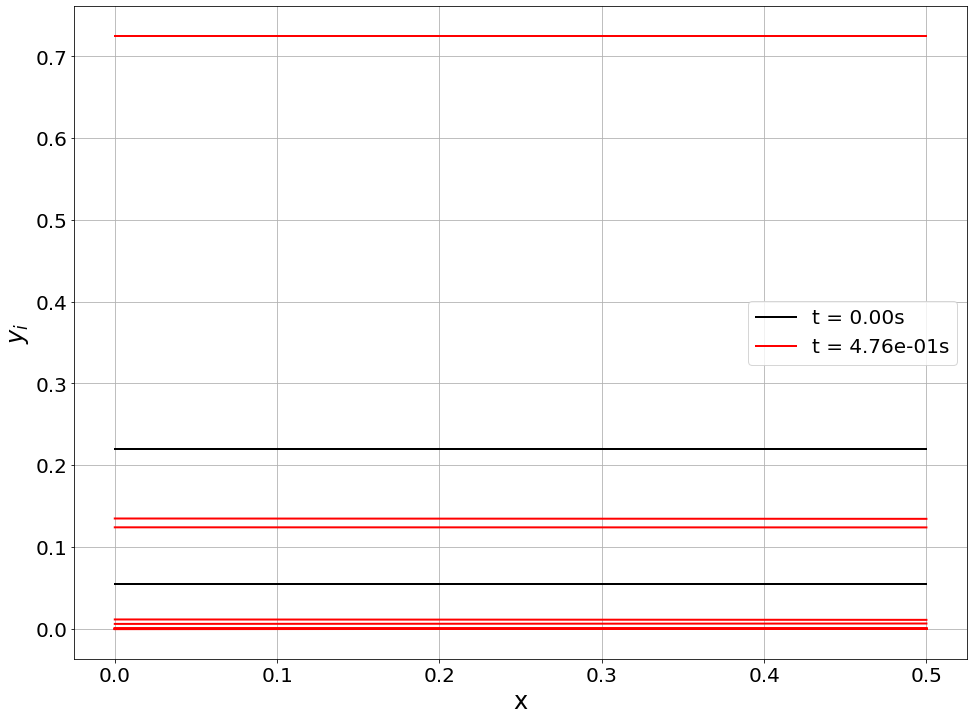

In [9]:
fig = plt.figure(figsize=(16, 12))

jt = 0
iS = 0
plt.plot(x[0+iS*nx:nx+iS*nx], yMat[iS,0+jt*nx:nx+jt*nx],  'k-', label='t = '+'{:.2f}'.format(tVec[jt])+'s')  
for iS in range(1,ns-1):
    plt.plot(x[0+iS*nx:nx+iS*nx], yMat[iS,0+jt*nx:nx+jt*nx],  'k-')  

jt = Nt-1
plt.plot(x[0+iS*nx:nx+iS*nx], yMat[iS,0+jt*nx:nx+jt*nx],  'r-', label='t = '+'{:.2e}'.format(tVec[jt])+'s') 
for iS in range(1,ns-1):
    plt.plot(x[0+iS*nx:nx+iS*nx], yMat[iS,0+jt*nx:nx+jt*nx],  'r-') 

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$y_i$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)

#plt.savefig(FigDir+'/yEnd.png', dpi=900)

In [10]:
# U, S, VT = np.linalg.svd(yMat.T, full_matrices=1)
# V        = VT.T

# fig1 = plt.figure(figsize=(16, 12))

# ax1 = fig1.add_subplot(121)
# ax1.semilogy(S,'-o',color='k')
# ax1.set_xlabel('Index', fontsize=24)
# ax1.set_ylabel('Singular Value', fontsize=24)
# #ax1.set_xticks(fontsize=20)
# #ax1.set_yticks(fontsize=20)

# ax2 = fig1.add_subplot(122)
# ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
# ax2.set_xlabel('Index', fontsize=24)
# ax2.set_ylabel('Energy', fontsize=24)
# #ax2.set_xticks(fontsize=20)
# #ax2.set_yticks(fontsize=20)

# plt.show()

nsClean =  16


Text(0, 0.5, '$\\theta_i$ at t=0 [s]')

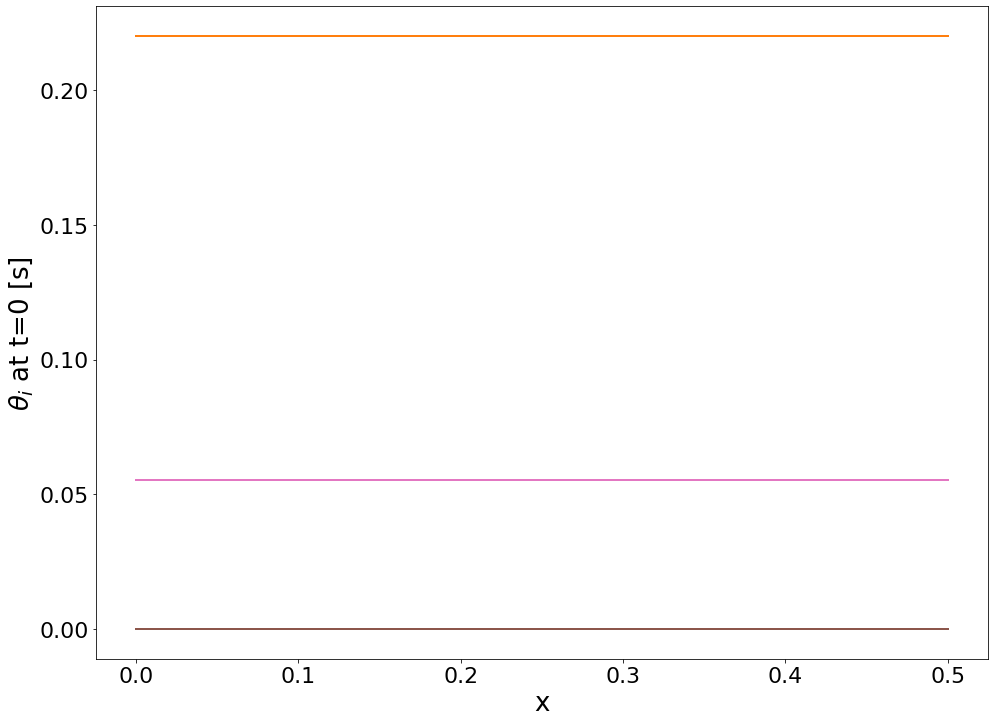

In [11]:
ConstVars  = (np.abs(yMat[:,nx]-yMat[:,-1]) < 1.e-6) & (yMat[:,nx] > 1.e-4)
ConstIdx   = [i for i in range(ns) if ConstVars[i]]
ConstVals  = yMat[ConstIdx,nx]
SmallVars  = (np.max(yMat.T, axis=0) < 1.e-6)
RemoveVars = list(  ConstVars | SmallVars )
KeepVars   = list(~(ConstVars | SmallVars))

yCleanNames= [yOrigNames[i] for i in range(len(yOrigNames)) if KeepVars[i]]
yPDClean   = DF[yCleanNames]
yClean     = yPDClean.to_numpy()
#yClean     = np.maximum(yClean, 1.e-20)
nsClean    = yClean.shape[1]
print('nsClean = ', nsClean)


fig = plt.figure(figsize=(16, 12))
plt.plot(yClean)
plt.yscale('log')


Y0Clean    = np.zeros((nsClean,nx))
iSClean    = 0
MaskClean  = np.zeros(nsClean, dtype=int)
CleanMask  = np.zeros(ns, dtype=int)
for iS in range(ns):
    if KeepVars[iS]:
        # Y0Clean[iSClean,,:] = 1.0 / ( sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (X[iS,:]-Lx/2)/sig )**2. ) * gas.Y[iS]    
        Y0Clean[iSClean,:]  = np.ones(nx) * Y0[iS,:]
        MaskClean[iSClean]  = iS
        CleanMask[iS]       = iSClean
        iSClean            += 1
        
y0Clean = Y0Clean.T.flatten()        

fig = plt.figure(figsize=(16, 12))
plt.plot(xx, Y0Clean.T)
plt.xlabel('x')
plt.ylabel(r'$\theta_i$ at t=0 [s]')

#plt.savefig(FigDir+'/y0Clean.png', dpi=900)

In [12]:
ns_Red          = nsClean

# from sklearn.decomposition import PCA
# pca             = PCA(n_components=ns_Red, whiten=False)
# yMat_pca        = (np.ascontiguousarray(pca.fit_transform(yMat.T))).T
# yMat_filtered   = pca.inverse_transform(yMat_pca.T)
# singular_values = pca.singular_values_
# AT              = pca.components_.T
yMean           = np.zeros((nsClean,1))#pca.mean_[...,np.newaxis]
# A               = AT.T
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean

from PCAfold import PCA as PCAA
pca        = PCAA(yClean, scaling='pareto', n_components=ns_Red)
yMat_pca   = pca.transform(yClean, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:ns_Red].T
L          = pca.L
AT         = A.T
# yMat_pca   = ((yMat.T - C)/D).dot(A)
yMat_      = pca.reconstruct(yMat_pca, nocenter=False)


# A                 = VT
# AT                = V
# yMat_pca          = np.matmul(yMat.T, V).T
# yMean             = np.zeros((ns_Red,1))
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean

# ns_Red            = ns
# A                 = np.zeros((ns_Red, ns_Red), int)
# np.fill_diagonal(A, 1)
# AT                = A.T
# yMat_pca          = np.matmul(A, yMat)
# yMean             = np.zeros((ns_Red,1))
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean

# from scipy.stats import ortho_group
# A                 = ortho_group.rvs(dim=ns_Red)
# AT                = A.T
# yMat_pca          = np.matmul(A, yMat)
# yMean             = np.zeros((ns_Red,1))
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean


## For Verification: 
print('Shape of yMat_pca = ', yMat_pca.shape)
print('Shape of A        = ', A.shape)
print('Error = ', np.max(abs(yClean - yMat_)))

Shape of yMat_pca =  (396, 16)
Shape of A        =  (16, 16)
Error =  7.979727989493313e-17


In [13]:
#DIFFUSION-REACTION OF MULTIPLE SCALARS - REDUCED

X_Red  = X
Y0_Red = pca.transform(Y0Clean.T, nocenter=False).T
y0_Red = np.zeros((ns_Red*nx))
for i in range(0,ns_Red):
    y0_Red[0+i*nx:nx+i*nx] = Y0_Red[i,:]

    
y0_Red = Y0_Red.T.flatten()
    
    
## For Verification: 
Y0_    = pca.reconstruct(Y0_Red.T, nocenter=False).T
print(np.max(abs(Y0Clean-Y0_)))

4.163336342344337e-17


Text(0, 0.5, '$\\theta_i$ at t=0 [s]')

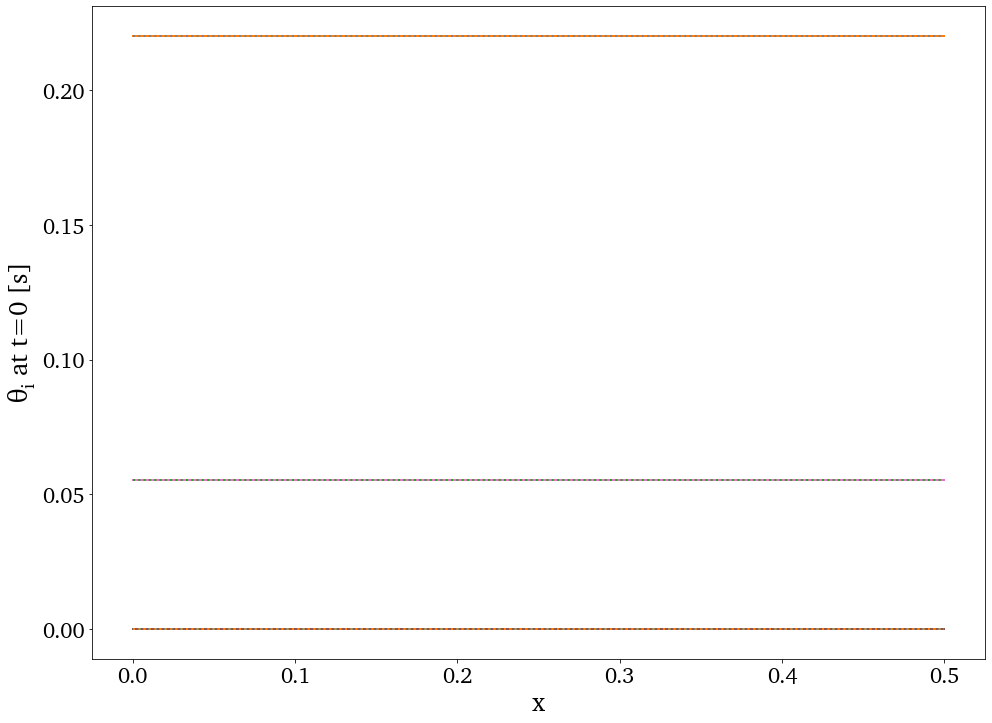

In [14]:
fig = plt.figure(figsize=(16, 12))
plt.plot(xx, Y0Clean.T)
plt.plot(xx, Y0_.T, ':')
plt.xlabel('x')
plt.ylabel(r'$\theta_i$ at t=0 [s]')

#plt.savefig(FigDir+'/y0Clean.png', dpi=900)

In [15]:
DiffC1Clean  = DiffC1[MaskClean]
DiffC2Clean  = DiffC2[MaskClean]

AdvecC1Clean = AdvecC1[MaskClean]
AdvecC2Clean = AdvecC2[MaskClean]

APCA         = A

In [16]:
# #####################################################################################################
# ### RHS Function
# def ReacDiffAdvRHS_PCA_x(x, y):
#     #print(x)
    
#     ns_       = ns
#     #ns_       = nsClean
#     #ns_       = ns_Red

#     Y         = y.reshape(nx,ns_)

#     dYdt_Diff = np.zeros((nx,ns_))
#     Y_Adv     = np.zeros((nx,ns_))
#     for iX in range(-1,nx-1):
#         DiffM_Red       = DiffFun(xx[iX],  DiffC1Clean, DiffC2Clean)
#         DiffM_Red       = np.matmul( APCA, np.matmul(DiffM_Red, APCA.T) )
#         dYdt_Diff[iX,:] = np.matmul(DiffM_Red, (Y[iX+1,:] - Y[iX-1,:]) / (2.*dx) )
#         AdvecM_Red      = AdvecFun(xx[iX], AdvecC1Clean, AdvecC2Clean)
#         AdvecM_Red      = np.matmul( APCA, np.matmul(AdvecM_Red, APCA.T) )
#         Y_Adv[iX,:]     = np.matmul(AdvecM_Red, Y[iX,:])
        
#     dYdt      = np.zeros((nx,ns_))    
#     for iX in range(-1,nx-1):
#         Diff       = (dYdt_Diff[iX+1,:] - dYdt_Diff[iX-1,:]) / (2.*dx)
#         Advec      = (    Y_Adv[iX+1,:] -     Y_Adv[iX-1,:]) / (2.*dx)
       	
#         #YClean           = pca.reconstruct(Y[iX,:][np.newaxis,...], nocenter=False)
#         #YOrig            = np.zeros(ns) 
#         #YOrig[MaskClean[:]] = YClean[0,:]
#         YOrig            = Y[iX,:]
        
#         gas.TDY          = T, rho0, YOrig
#         wdot             = gas.net_production_rates
#         ReacOrig         = wdot * gas.molecular_weights / rho0   
#         ReacClean        = ReacOrig#[MaskClean]
#         Reac             = pca.transform(ReacClean[np.newaxis,:], nocenter=True)

#         dYdt[iX,:] = Reac#+ Diff + Advec #+ 

#     dydt = dYdt.flatten() 

#     #sys.exit('Enough')
#     return dydt


#####################################################################################################
### RHS Function
def ReacDiffAdvRHS_PCA_x(x, y):
    #print(x)
    
    ns_       = ns
    #ns_       = nsClean
    #ns_       = ns_Red

    Y         = y.reshape(nx,ns_)

    dYdt      = np.zeros((nx,ns_))    
    for iX in range(-1,nx-1):
    
        #YClean              = pca.reconstruct(Y[iX,:][np.newaxis,...], nocenter=False)
        YClean              = Y[iX,:][np.newaxis,...]
        
        #YOrig               = np.zeros(ns) 
        #YOrig[MaskClean[:]] = YClean[0,:]
        #YOrig[ConstIdx[:]]  = ConstVals

        gas_.TDY            = T_, rho0_, Y[iX,:]#YOrig
        wdot                = gas_.net_production_rates
        ReacOrig            = wdot * gas_.molecular_weights / rho0   
        #ReacClean           = ReacOrig[MaskClean[:]]

        #Reac                = pca.transform(ReacClean[np.newaxis,:], nocenter=True)
        Reac                = ReacOrig
        
        dYdt[iX,:]          = ReacOrig[0::] #+ Diff + Advec #+ 

    dydt = dYdt.flatten() 

    #sys.exit('Enough')
    return dydt

In [17]:
# ---------------------------------------------------------------------------------------------------
### Integrate and Unpack


gas_        = ct.Solution('gri30.yaml', energy_enabled=False)
gas_.TPX    = T0, P0, 'CH4:0.5, O2:1, N2:3.76'
T_          = TTran
rho0_       = gas_.density


tVec     = [0.0]
t        = tMin
dt       = dt0
while (t <= tMax):
    tVec.append(t)
    t   = t + dt
    dt *= tStratch
Nt = len(tVec)


xMat  = np.zeros((ns,nx))
for i in range(0,ns):
    xMat[i,:] =  x[0+i*nx:nx+i*nx]



y0_       = y0All
#y0_       = y0Clean
#y0_       = y0_Red
output    = solve_ivp( ReacDiffAdvRHS_PCA_x, (tVec[0],tVec[-1]), y0_, method='BDF')

In [18]:
y_next    = []
Nt        = output.y.shape[1]
for it in range(Nt):
    y_next.append(output.y[:,it])

ns_   = int(output.y.shape[0]/nx)
yTemp = np.zeros((ns_,nx))
for it in range(Nt):
    for ix in range(0,nx):
        yTemp[0:ns_,ix] = y_next[it][ix*(ns_):(ix+1)*(ns_)]
    if (it == 0):
        yMat_Red = yTemp+0
    else:
        yMat_Red = np.concatenate((yMat_Red,yTemp), axis=1)

tVecRed = output.t

ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

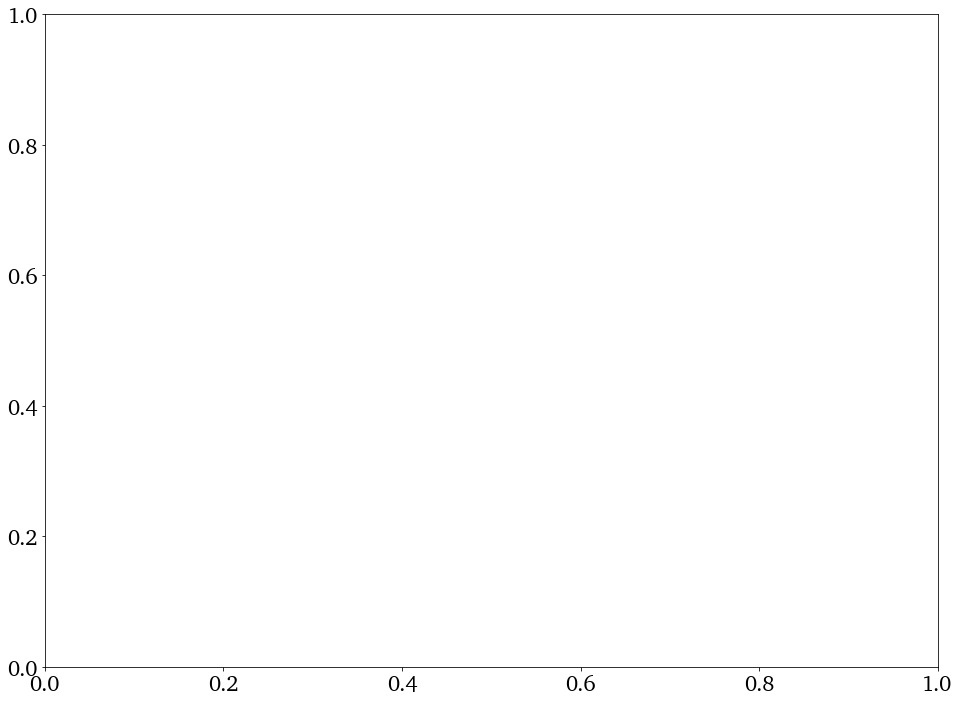

In [19]:
ColorVec = ['k','r','b','y','g','m','c']*10


fig = plt.figure(figsize=(16, 12))

nt    = int(yMat_Red.shape[1]/nx)
it    = nt
for i in range(0,ns_Red):
    plt.plot(x[0+i*nx:nx+i*nx],yMat_Red[i,0+it*nx:nx+it*nx], ColorVec[i]+'-', label=r'$\eta_{'+str(i+1)+'}$')  #solutions at time t=t1

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\eta_i$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [ ]:
ColorVec = ['k','r','b','y','g','m','c']*10

#yMat_ = pca.reconstruct(yMat_Red.T, nocenter=False).T
yMat_ = yMat_Red.T

# for i in range(0,ns):
#     plt.plot(x[0+i*nx:nx+i*nx],y0[0+i*nx:nx+i*nx], 'b-')  #initial condition
fig = plt.figure(figsize=(16, 12))

ntClean = int(yClean.T.shape[1]/nx)
itClean = ntClean-1
nt      = int(yMat_.shape[1]/nx)
it      = nt-1
for i in range(0,nsClean):
    plt.plot(x[0+i*nx:nx+i*nx],yClean.T[i,0+itClean*nx:nx+itClean*nx], ColorVec[i]+'-', label=r'$y_{'+str(i+1)+'}$')  #solutions at time t=t1
    plt.plot(x[0+i*nx:nx+i*nx],yMat_.T[i,0+it*nx:nx+it*nx], ColorVec[i]+':')  #solutions at time t=t1

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$y_i$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

In [ ]:
iIdx = 2

plt.plot(tVec, yClean[::2,iIdx])
plt.plot(tVecRed, yMat_[::2,iIdx])
plt.yscale('log')

In [ ]:
yClean[0,:]